In [1]:
# Install required packages quietly
import subprocess
import sys

required = [
    "torch", "torchvision", "timm", "opencv-python", "numpy", "scipy",
    "scikit-learn", "matplotlib", "Pillow", "tqdm", "scikit-image",
    "distinctipy"
]

for pkg in required:
    subprocess.run([sys.executable, "-m", "pip", "install", pkg], capture_output=True, text=True)

# Create standard folders
import os
folders = ["results", "models", "data", "logs"]
for folder in folders:
    os.makedirs(folder, exist_ok=True)


In [2]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import os
import glob
from scipy import ndimage
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects
import distinctipy

# Seed for reproducibility
np.random.seed(42)
print("Setup complete.")


Setup complete.


In [3]:
# Find all images in the silk_dataset folder
dataset_folder = "silk_dataset"
exts = [".jpg", ".jpeg", ".png", ".bmp", ".tiff"]
silk_image_paths = []

for ext in exts:
    silk_image_paths += glob.glob(os.path.join(dataset_folder, f"*{ext}"))
    silk_image_paths += glob.glob(os.path.join(dataset_folder, f"*{ext.upper()}"))

silk_image_paths = sorted(list(set(silk_image_paths)))
print(f"Found {len(silk_image_paths)} input images.")


Found 1351 input images.


In [4]:
class DirectSilkwormSegmentor:
    def __init__(self, min_obj_size=150, min_distance=10):
        self.min_obj_size = min_obj_size
        self.min_distance = min_distance

    def _create_silkworm_mask(self, image):
        """
        Creates a binary mask of the silkworms using HSV color thresholding.
        """
        # Convert the image to the HSV color space
        hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        
        # Define the color range for silkworms (low saturation, high brightness)
        # These values can be tuned if needed for different lighting conditions
        lower_bound = np.array([0, 0, 150])
        upper_bound = np.array([180, 50, 255])
        
        # Create a mask that selects pixels within the defined range
        mask = cv2.inRange(hsv_image, lower_bound, upper_bound)
        
        return mask

    def _refine_mask(self, mask):
        """
        Cleans the binary mask using morphological operations.
        """
        # Remove small, noisy objects
        cleaned = remove_small_objects(mask.astype(bool), min_size=self.min_obj_size)
        
        # Close small holes in the remaining objects
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        refined = cv2.morphologyEx(cleaned.astype(np.uint8), cv2.MORPH_CLOSE, kernel, iterations=2)
        
        return refined

    def run(self, image_path):
        """
        Executes the full segmentation pipeline on a given image.
        """
        original_image = np.array(Image.open(image_path).convert('RGB'))
        
        # 1. Isolate silkworms by color
        silkworm_mask = self._create_silkworm_mask(original_image)
        
        # 2. Refine the mask
        refined_mask = self._refine_mask(silkworm_mask)
        
        if not np.any(refined_mask):
            return [], refined_mask, 0

        # 3. Segment instances using watershed
        distance = ndimage.distance_transform_edt(refined_mask)
        coords = peak_local_max(distance, min_distance=self.min_distance, labels=refined_mask)
        
        markers_mask = np.zeros(distance.shape, dtype=bool)
        markers_mask[tuple(coords.T)] = True
        markers, _ = ndimage.label(markers_mask)
        
        instance_labels = watershed(-distance, markers, mask=refined_mask)
        
        instances = []
        for label_id in np.unique(instance_labels):
            if label_id == 0: continue
            instances.append((instance_labels == label_id).astype(np.uint8))

        return instances, refined_mask, len(instances)

# Instantiate the new segmentor
pipeline = DirectSilkwormSegmentor()


In [5]:
def plot_segmentation_visualization(image_path, results):
    orig = np.array(Image.open(image_path).convert("RGB"))
    
    instance_masks, initial_mask, silkworm_count = results
    
    # --- Image 1: The Initial Color-Based Mask ---
    mask_display = cv2.cvtColor(initial_mask * 255, cv2.COLOR_GRAY2BGR)
    
    # --- Image 2: Final Instance Segmentation ---
    instance_img = orig.copy()
    if instance_masks:
        instance_colors = distinctipy.get_colors(len(instance_masks))
        for i, mask in enumerate(instance_masks):
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            color_bgr = [c * 255 for c in instance_colors[i]][::-1]
            cv2.drawContours(instance_img, contours, -1, color_bgr, 2)
    
    # Plot results
    f, ax = plt.subplots(1, 3, figsize=(20, 7))
    ax[0].imshow(orig)
    ax[0].set_title("Original Image")
    ax[1].imshow(mask_display)
    ax[1].set_title("Initial Silkworm Mask (from Color)")
    ax[2].imshow(instance_img)
    ax[2].set_title(f"Final Instance Segmentation ({silkworm_count} Silkworms)")
    
    for a in ax: a.axis("off")
    plt.tight_layout()
    plt.show()


Processing image: silk_dataset\IMG_3311.jpg with the new direct segmentation approach.

Total silkworm instances detected: 981


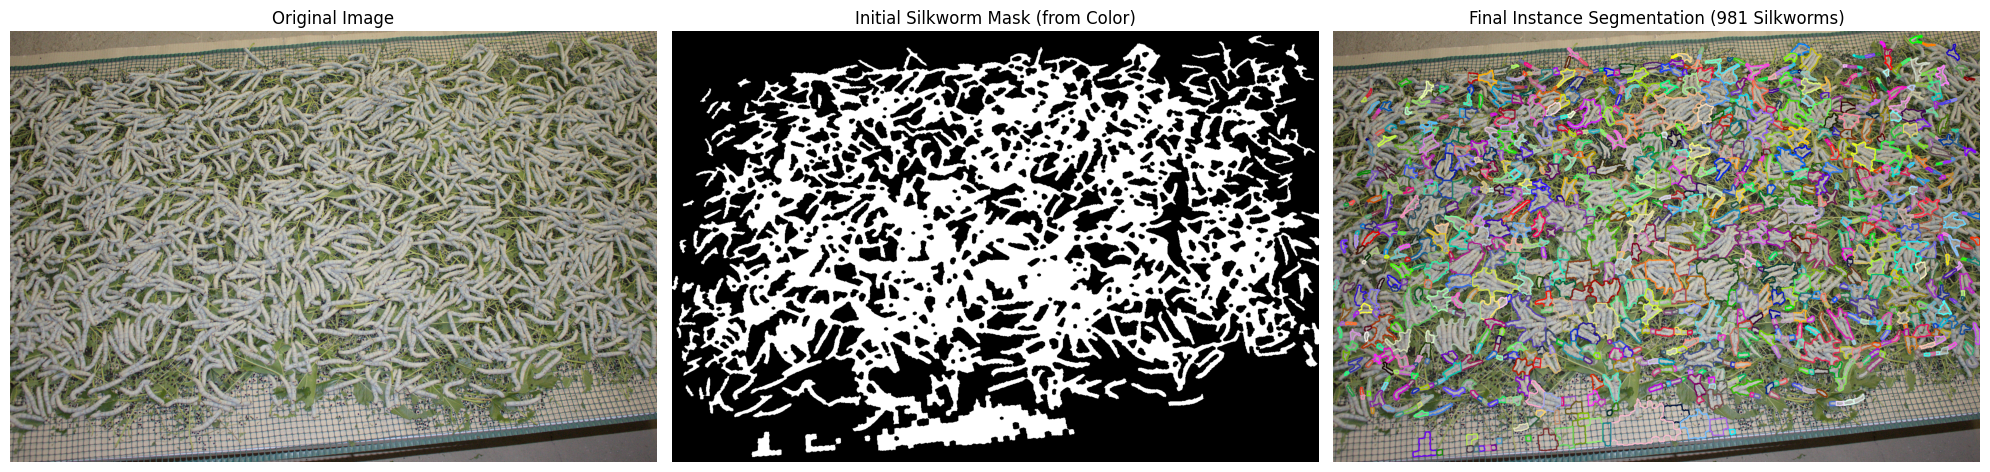

In [7]:
# Define the specific image you want to process
image_name = "IMG_3311.jpg" # Using one of the challenging images
image_path = os.path.join(dataset_folder, image_name)

# Check if the specified image exists before running the pipeline
if os.path.exists(image_path):
    print(f"Processing image: {image_path} with the new direct segmentation approach.")
    
    # Run the full segmentation pipeline
    # The pipeline now directly returns the results needed for plotting
    results = pipeline.run(image_path)
    
    # Print summary and display visualization
    print(f"\nTotal silkworm instances detected: {results[2]}")
    
    plot_segmentation_visualization(image_path, results)
else: 
    print(f"Error: The image '{image_name}' was not found in the '{dataset_folder}' folder.")
    print("Please make sure the file exists and the name is correct.")


Processing image: silk_dataset\IMG_3322.jpg with the new direct segmentation approach.

Total silkworm instances detected: 51


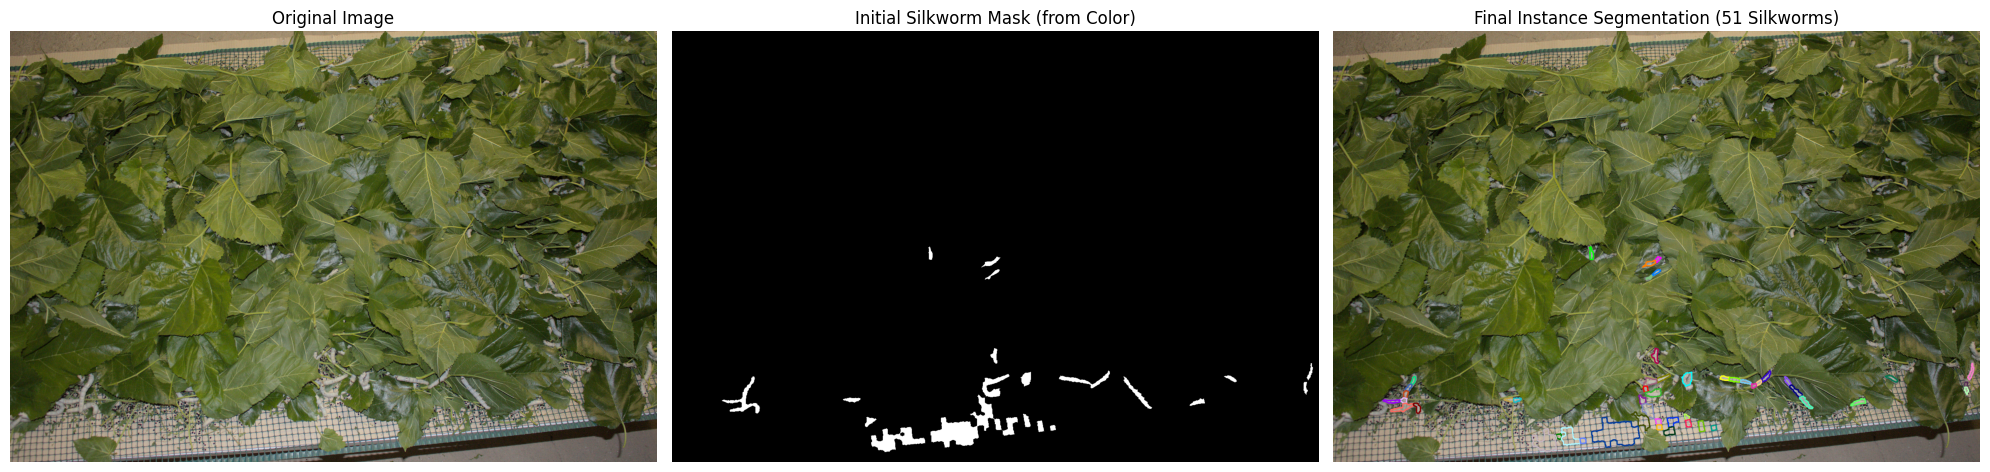

In [8]:
# Define the specific image you want to process
image_name = "IMG_3322.jpg" # Using one of the challenging images
image_path = os.path.join(dataset_folder, image_name)

# Check if the specified image exists before running the pipeline
if os.path.exists(image_path):
    print(f"Processing image: {image_path} with the new direct segmentation approach.")
    
    # Run the full segmentation pipeline
    # The pipeline now directly returns the results needed for plotting
    results = pipeline.run(image_path)
    
    # Print summary and display visualization
    print(f"\nTotal silkworm instances detected: {results[2]}")
    
    plot_segmentation_visualization(image_path, results)
else: 
    print(f"Error: The image '{image_name}' was not found in the '{dataset_folder}' folder.")
    print("Please make sure the file exists and the name is correct.")


Processing image: silk_dataset\IMG_3290.jpg with the new direct segmentation approach.

Total silkworm instances detected: 790


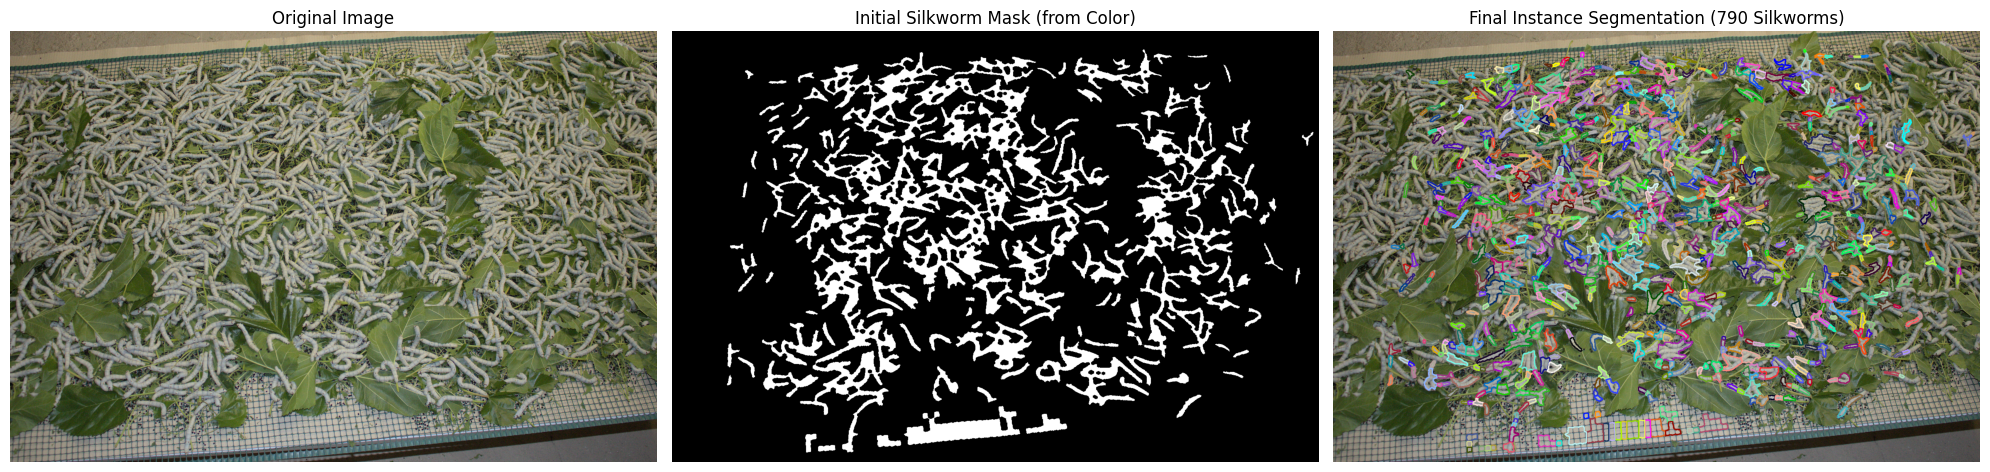

In [9]:

# Define the specific image you want to process
image_name = "IMG_3290.jpg" # Using one of the challenging images
image_path = os.path.join(dataset_folder, image_name)

# Check if the specified image exists before running the pipeline
if os.path.exists(image_path):
    print(f"Processing image: {image_path} with the new direct segmentation approach.")
    
    # Run the full segmentation pipeline
    # The pipeline now directly returns the results needed for plotting
    results = pipeline.run(image_path)
    
    # Print summary and display visualization
    print(f"\nTotal silkworm instances detected: {results[2]}")
    
    plot_segmentation_visualization(image_path, results)
else: 
    print(f"Error: The image '{image_name}' was not found in the '{dataset_folder}' folder.")
    print("Please make sure the file exists and the name is correct.")
